# Research Notebook
## Rodrigo Terezon
## Date: Feb 15 2026

# 1: Experience
## Describe at least one research activity you worked on this week. 

- Began plotting stable dark sector phase transition posteriors
- Plotted spectrum against frequencies
- Attempted to recreate figure 5.1 in [1]
- Compared generated plots to those from the source material (thesis)

## Motivation:

We want to verify results found in thesis [1], specifically figure 5.1 which plots the posterior of given dark sector phase transition parameters that is fitted to the NANOGrav 12.5 year dataset. In addition, we want to plot the best fit for spectrum against frequency obtained from MCMC sampling and compare results found in the thesis, figure 5.2 [1]. Doing these will be important so that our model agrees with the thesis and can be used for further analysis.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

The main goal was to recreate figure 5.1 in [1], this plot uses sound wave contributions, which are the main contribution in dark sector phase transitions. These are a source in generation of gravitational waves for first order phase transition. In the thesis, the sound wave contribution is stated in equation 4.33,

\begin{equation*}
h^{2}\Omega_{sw}(f)=\mathcal{R}h^{2}\tilde{\Omega}_{sw}(\frac{\kappa_{sw}\alpha}{\alpha+1})^{2}(\frac{\beta}{H})^{-1}\gamma_{sh}s_{sw}(f/f_{p,sw})
\end{equation*}

Where,

\begin{equation*}
s_{sw}(x)=x^{3}(\frac{7}{4+3x^{2}})^{7/2}
\end{equation*}
and
\begin{equation*}
\gamma_{sh}\simeq min[1, \frac{3.38}{\beta/H}\sqrt{\frac{1+\alpha}{\kappa_{sw}\alpha}}]
\end{equation*}

In this case, $ \alpha $ is the phase transition strength, $ \frac{\beta}{H} $ is the rate of bubble nucleation, $ \gamma_{sh} $ is the lifetime of sound wave source, and $ \tilde{\Omega}_{sw} $ is the normalization of the signal. Additionally, $ \mathcal{R}h^{2} $ would be a redshift factor for the gravitational wave energy density observed today and is given by equation 4.35b,

\begin{equation*}
\mathcal{R}h^{2}=\frac{1.7\times 10^{-5}}{D^{4/3}}(\frac{g^{P}_{tot}}{100})(\frac{100}{h^{P}_{tot}})^{4/3}
\end{equation*}

Where D is the dillution factor (set to 1, in this case), g is the energy density degrees of freedom, and h is the entropy degrees of freedom. In addition, the contribution from the bubble wall collisions is coded in but not used in the plotting of the stable dark sector phase transition, it is defined in equation 4.32 [1],

\begin{equation*}
h^{2}\Omega_{bw}(f)=\mathcal{R}h^{2}\tilde{\Omega}_{bw}(\frac{\kappa_{\phi}\alpha}{\alpha+1})^{2}(\frac{\beta}{H})^{-2}s_{bw}(f/f_{p,bw})
\end{equation*}

The term $ \xi_{p} $ is not explicitly used, I tried to implement it however it resulted in undesirable posteriors and was likely implemented incorrectly. $ \xi_{p} $ is ratio of dark-sector temperature to visible-sector temperature at the moment of percolation. These are the parameters used for the MCMC sampling:

    parameters = {
        'log_alpha'   : prior("Uniform", -2, 0),
        'log_beta_h'  : prior("Uniform", 0, 3),
        'log_Tp_GeV'      : prior("Uniform", -4, -1),
        'log_eps_p'   : prior("Uniform", -2, 1),
    }

The spectrum code is as follows:

    def spectrum(f, log_alpha, log_beta_h, log_Tp_GeV, log_eps_p):

        alpha = 10**log_alpha
        beta_h = 10**log_beta_h
        Tp_Gev = 10**log_Tp_GeV
        eps_p = 10**log_eps_p

        g_SM_rho = 100
        g_SM_s   = 100

        Tp_SM = Tp_Gev

        pref_f = 16.5e-9 * beta_h * (Tp_SM / 0.1) * (g_SM_rho / 100)**0.5 * (100 / g_SM_s)**(1/3)

        f_pbw = pref_f * 0.23
        f_psw = pref_f * 0.53

        omega_bw = 0.077
        omega_sw = 0.072
        k_phi = 0 # No bubble wall collisions contributions
        k_sw = 1 # Only sound waves contributions
        Rh2 = 1.653e-5 * (g_SM_rho / 100) * (100 / g_SM_s)**(4/3)
        Y_sh_term = y_sh(alpha, beta_h, k_sw)

        pref_bw = ((k_phi * alpha) / (1.0 + alpha))**2
        h2_omega_bw = Rh2 * omega_bw * pref_bw * beta_h**(-2) * S_bw(f / f_pbw)

        pref_sw = ((k_sw * alpha) / (1.0 + alpha))**2
        h2_omega_sw = Rh2 * omega_sw * pref_sw * beta_h**(-1) * Y_sh_term * S_sw(f / f_psw)

        return h2_omega_bw + h2_omega_sw

Finally, the gravitational wave spectrum was plotted against frequency. Since our model uses MCMC sampling, we want to find the best fit values for our parameters, this was done by using the following code:

    import numpy as np
    from pathlib import Path

    chain_file = Path("Rodrigo/dspt/chains_dspt/np_model/chain_0/chain_1.txt")
    pars_file  = Path("Rodrigo/dspt/chains_dspt/np_model/chain_0/pars.txt")

    chain = np.loadtxt(chain_file)

    with open(pars_file) as f:
        par_names = [l.strip() for l in f if l.strip()]

    par_index = {name: i for i, name in enumerate(par_names)}

    i_logTp   = par_index["log_Tp_GeV"]
    i_loga    = par_index["log_alpha"]
    i_logbh   = par_index["log_beta_h"]
    i_logeps  = par_index["log_eps_p"]
    i_nmodel  = par_index["nmodel"]

    i_post = -3

    imax = np.argmax(chain[:, i_post])

    logTp_map  = chain[imax, i_logTp]
    loga_map   = chain[imax, i_loga]
    logbh_map  = chain[imax, i_logbh]
    logeps_map = chain[imax, i_logeps]

    print(f"log_Tp_GeV = {logTp_map:.4f}")
    print(f"log_alpha  = {loga_map:.4f}")
    print(f"log_beta_h = {logbh_map:.4f}")
    print(f"log_eps_p  = {logeps_map:.4f}")

- Show code (in part 3 show plot and compare to thesis, maybe mention no xi_p contribution or how it changed the plots)
- Mention spectrum plotted against frequency (show code, how best values are found)
- in part 3, show the spectrum and compare to that of the thesis

# 3: So what? (What does it mean?)
## Describe your results

Now, my code generated the following plot:

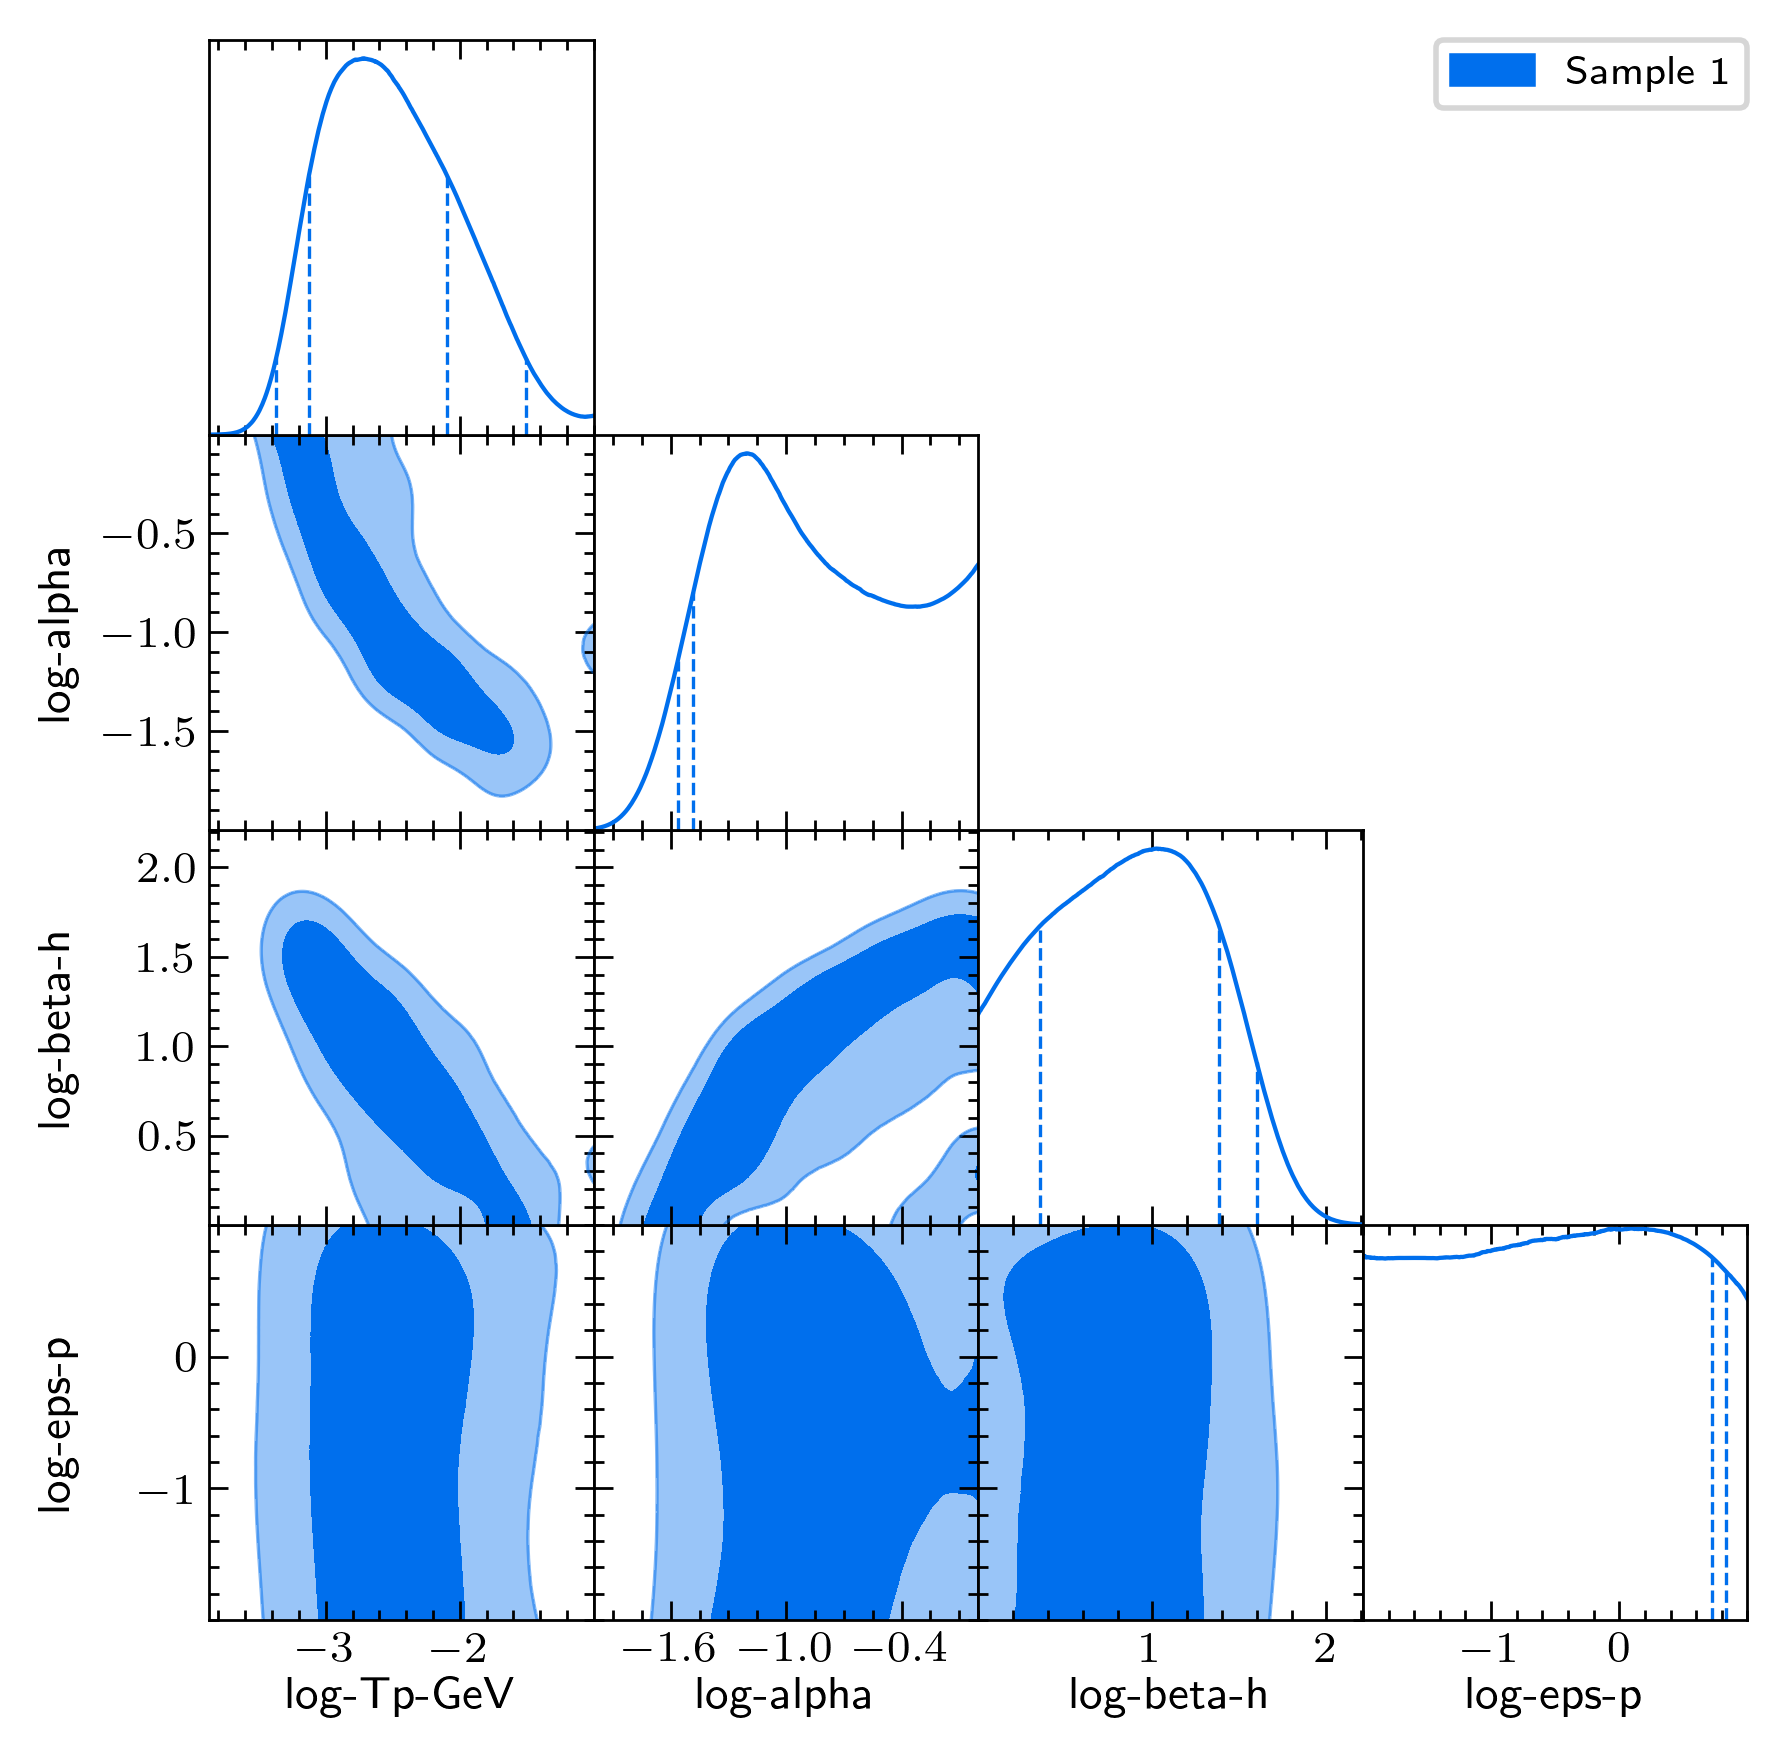

The goal was to attempt to recreate the following:

![Screenshot 2026-02-15 141624.png](<attachment:Screenshot 2026-02-15 141624.png>)

Although the axes are not the same, and $ \Delta N_{eff} $ is not included in the plot. If we compare the correct posteriors, we can see that the shape for many are similar, and that there is a defined shape. The defined shape indicates a strong correlation between the two values. It is worth noting that although $ \xi_{p} $ was sampled, it was not actually used anywhere in the equation. Including it resulted in posteriors that did not match up with expectations.

Additionally, the plot for our spectrum against frequency is shown as follows:

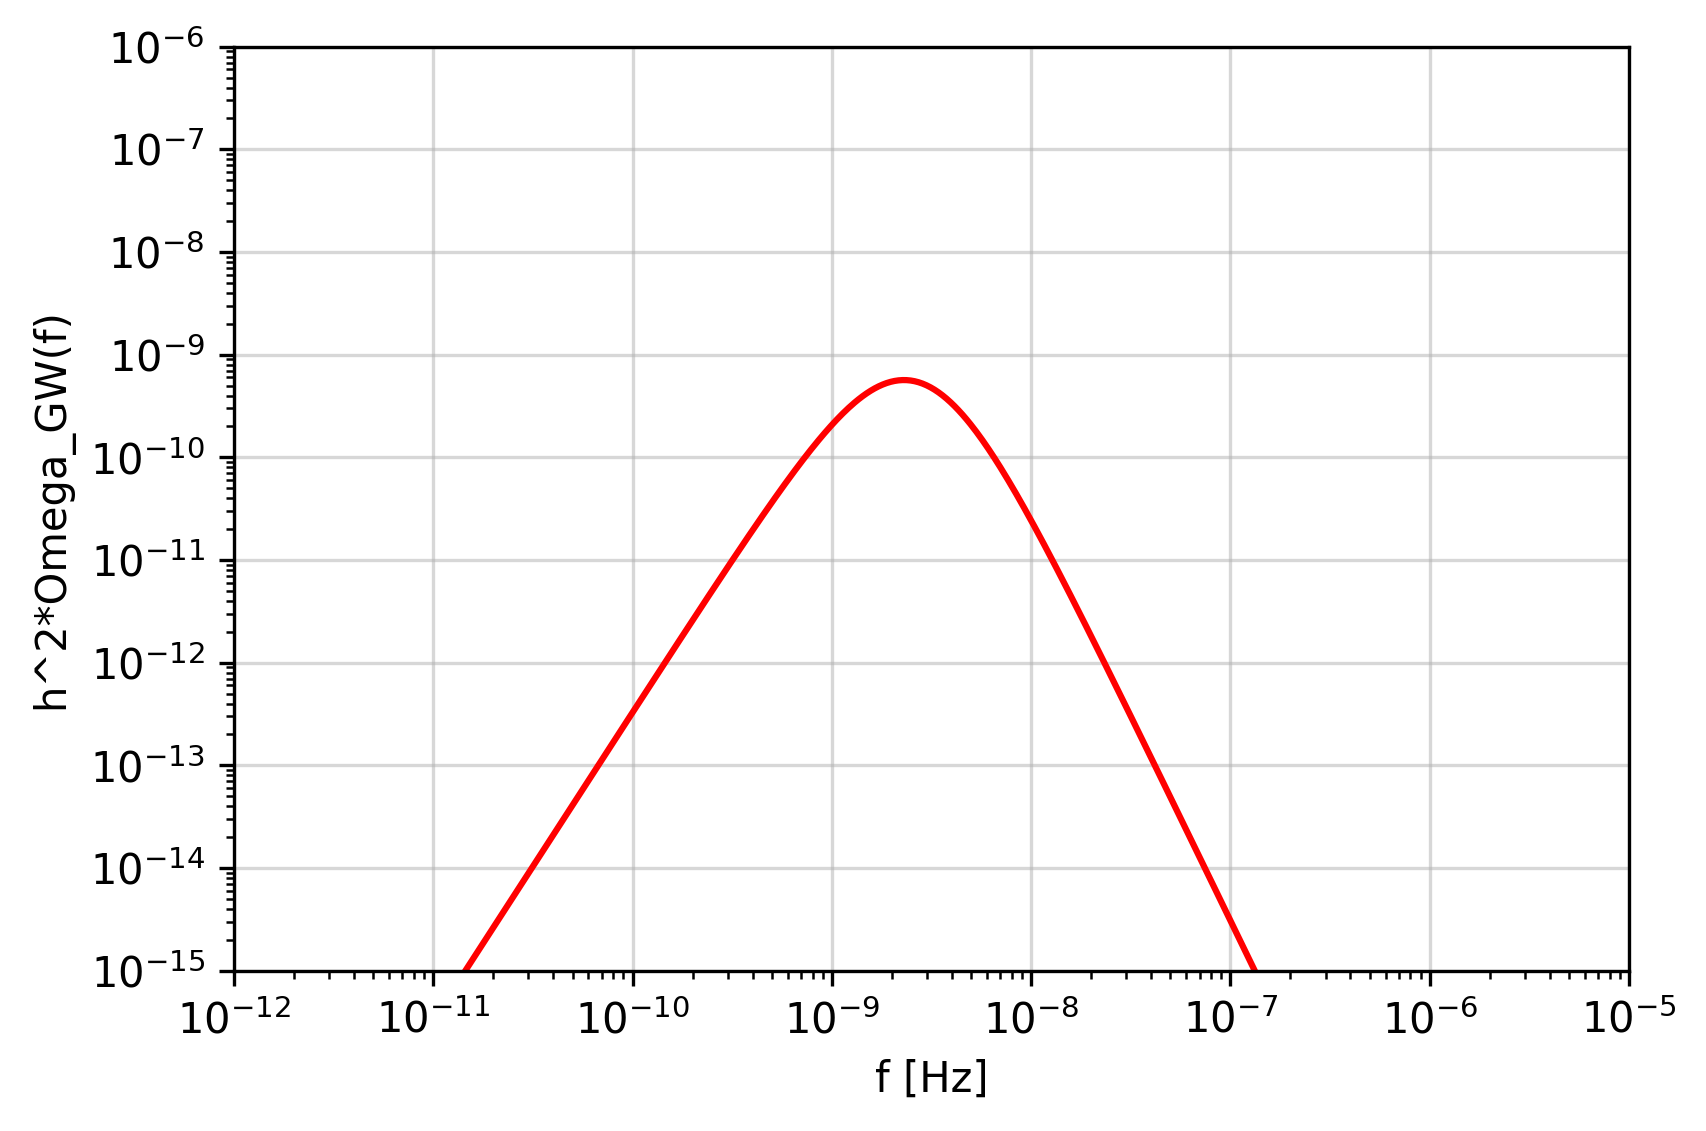

As we are using the same dataset (12.5 year NANOgrav) as in the thesis we expect a similar plot, the plot in the thesis is as follows:

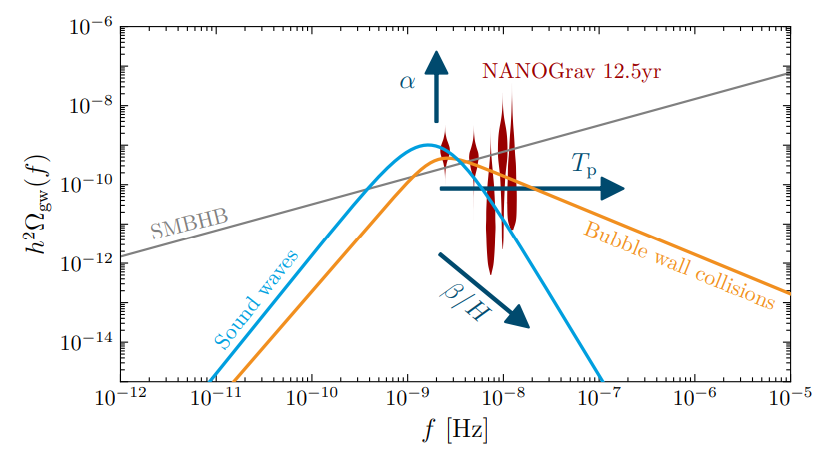

To compare the two more accurately, I overlayed my plot ontop:

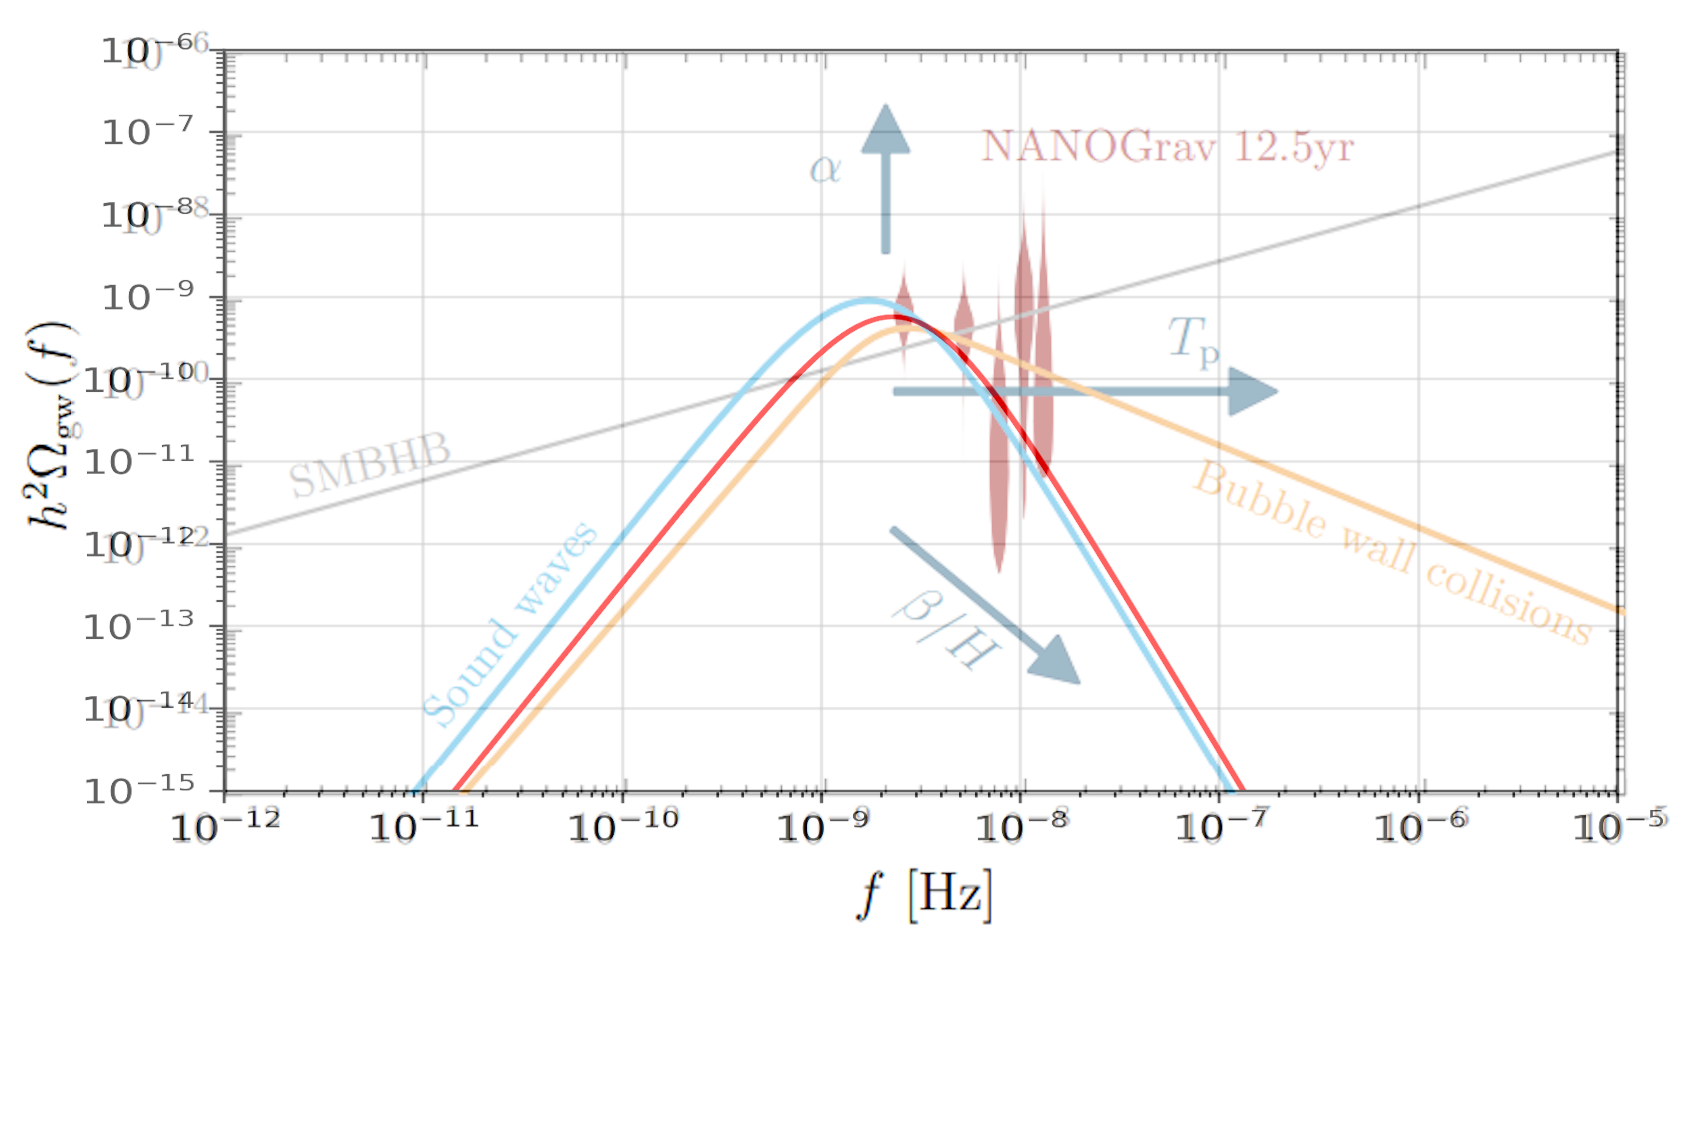

As can be seen, they follow the same trend for sound wave contributions. This is expected because we are using the same function. What is more important, is the spectrum values for each corresponding frequency. They are in the same magnitude which is ideal, as I mentioned earlier, the best values were found from the MCMC using code. These values were used when plotting the spectrum against frequency. When comparing the two, it is clear that they very similar, although mine is slightly shifted to the right.
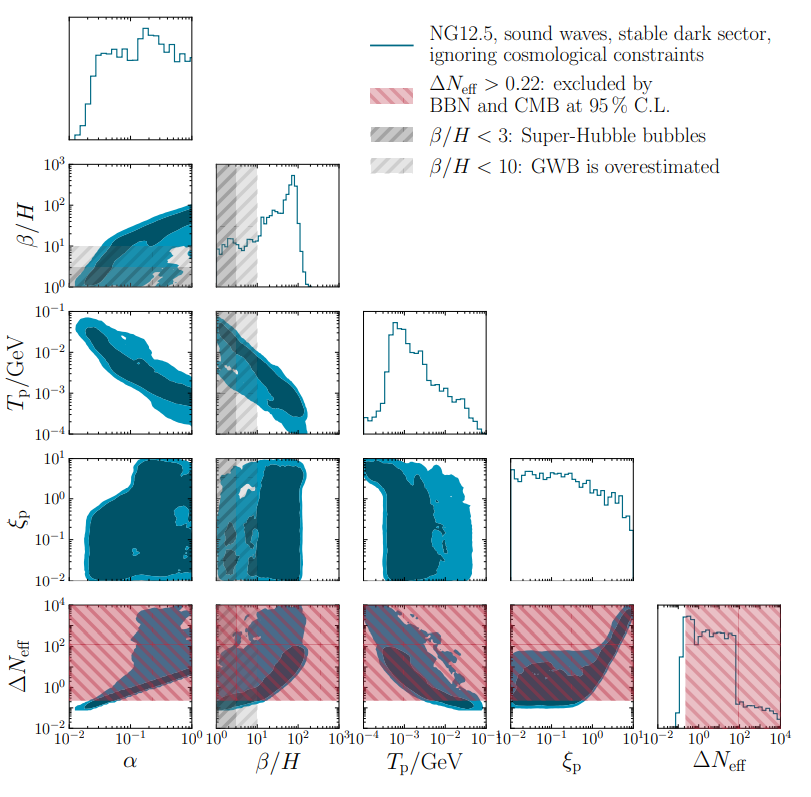

# 4. Now what? (What's next?)
## Plan for the next week

The thesis was read more in depth and used to help create my models that currently agree with the source.

- Attempt to recreate decaying dark sector phase transition figure 5.3 in [1].
- Implement contributions from $ \xi_{p} $ into sound wave contributions properly.
- Compare the spectrum against frequency for bubble wall contributions and sound wave contributions.

# 5. Bibliography

[1] Tasillo, C. (2023). *Exploring the Dark Universe with
Gravitational Wave Backgrounds*. Universität Hamburg. Retrieved from https://ediss.sub.uni-hamburg.de/bitstream/ediss/11329/1/PhD_thesis_Carlo_Tasillo_Bibversion.pdf
<br>
[2] Mitridate, A., & PTArcade contributors. (n.d.). *PTArcade: A Python toolkit for PTA gravitational-wave inference*. Retrieved Jan 25, 2026, from https://andrea-mitridate.github.io/PTArcade/
<br>
[3] Mitridate, A., Wright, D., & PTArcade contributors. (2023). *PTArcade*. arXiv. https://arxiv.org/abs/2306.16377